# Human Value and Comment Topic Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit

## General Topic Distribution

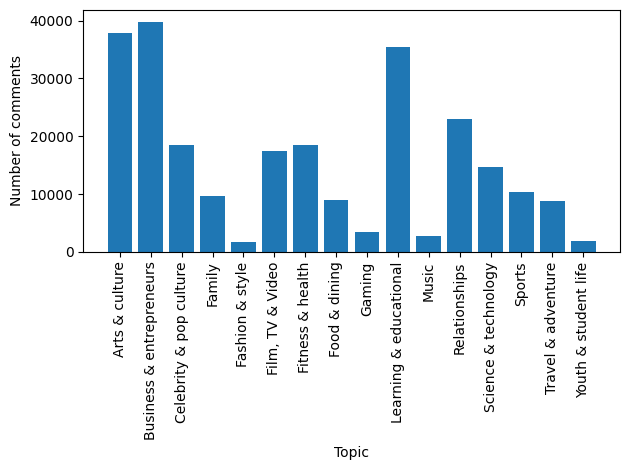

In [2]:
all_topic_scores_raw = np.load("all_scores.npy")
all_topic_scores = np.empty((all_topic_scores_raw.shape[0], 16))
topic_counts = [0 for _ in range(16)]
topic_labels = ['Arts & culture', 'Business & entrepreneurs', 'Celebrity & pop culture',
          'Family', 'Fashion & style',
          'Film, TV & Video', 'Fitness & health', 'Food & dining',
          'Gaming', 'Learning & educational', 'Music',
          'Relationships',
          'Science & technology', 'Sports', 'Travel & adventure',
          'Youth & student life']

for score_idx, raw_score in enumerate(all_topic_scores_raw):
    score = np.exp(raw_score)/sum(np.exp(raw_score))
    score = np.delete(score, [3, 12, 13])
    all_topic_scores[score_idx] = score
    topic_counts[np.argmax(score)] += 1

plt.bar(topic_labels, topic_counts)
plt.xticks(rotation=90)
plt.xlabel("Topic")
plt.ylabel("Number of comments")
plt.tight_layout()
plt.savefig(os.path.join("plots", "general_topic_distrib.pdf"))
plt.show()

## Topic Distribution per Human Value

In [3]:
# Gets the value labels
DATA_PATH = "data"

def get_value_labels(path=DATA_PATH):
    def get_path(set_type, is_args):
        return os.path.join(path, set_type, ("arguments" if is_args else "labels") + "-" + set_type + ".tsv")
    
    for set_type in ["test", "training", "validation"]:
        args = pd.read_csv(get_path(set_type, True), sep="\t")
        
        labels = pd.read_csv(get_path(set_type, False), sep="\t")
        labels = labels.drop("Argument ID", axis=1)
        args["Labels"] = [x for x in labels.to_numpy()]
        
    classes = list(labels.columns)
    
    return np.array(classes)

value_labels = get_value_labels()

### Predicted human values on CMV
Imports predicted human values and plots distribution

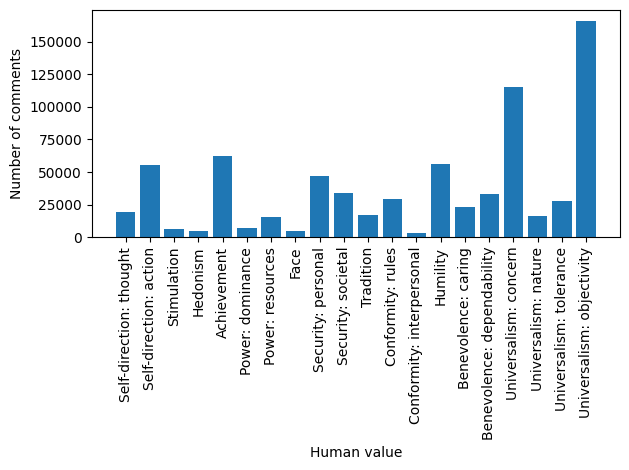

In [4]:
all_values_raw = np.load("all_values_correct.npy")
value_predictions = []
count_prediction = [0 for _ in range(len(value_labels))]

for idx, raw_score in enumerate(all_values_raw):
  score = expit(raw_score)
  predictions = (score >= 0.5) * 1
  predicted_values = np.argwhere(predictions).flatten().tolist()
  for value in predicted_values:
    count_prediction[value] += 1
  value_predictions.append(predicted_values)

plt.bar(value_labels, count_prediction)
plt.xticks(rotation=90)
plt.ylabel("Number of comments")
plt.xlabel("Human value")
plt.tight_layout()
plt.savefig(os.path.join("plots", "general_value_distrib.pdf"))
plt.show()

### Topic distribution analysis by human value

In [5]:
# Counts the number of comments per value and topic
count_topic_per_value = np.zeros((len(value_labels), len(topic_labels)))
for comment_idx in range(len(value_predictions)):
    for value in value_predictions[comment_idx]:
        topic = np.argmax(all_topic_scores[comment_idx])
        count_topic_per_value[value][topic] += 1

# Normalize the topic counts by the highest count
count_topic_per_value_norm = np.zeros((len(value_labels), len(topic_labels)))
for idx, value in enumerate(count_topic_per_value):
    count_topic_per_value_norm[idx] = np.around(value / np.amax(value), 2)

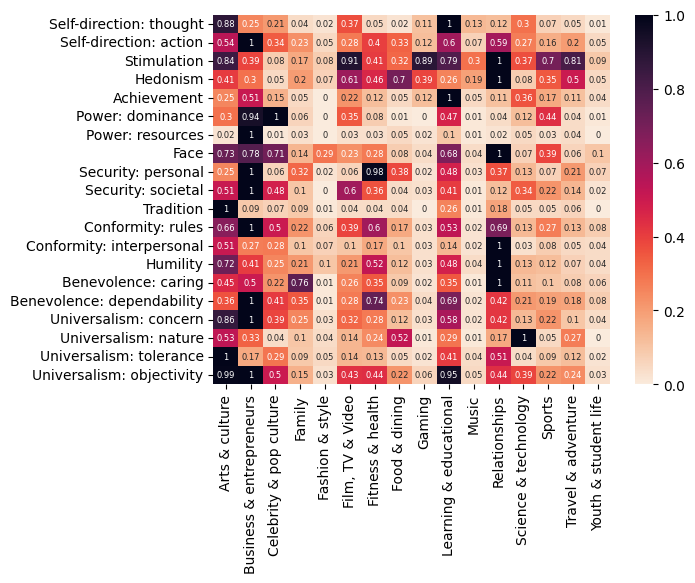

In [6]:
sns.heatmap(count_topic_per_value_norm, annot=True, annot_kws={"size": 6}, cmap=sns.cm.rocket_r, yticklabels=value_labels, xticklabels=topic_labels)
plt.savefig(os.path.join("plots", "value_topic_heatmap.pdf"), bbox_inches='tight')

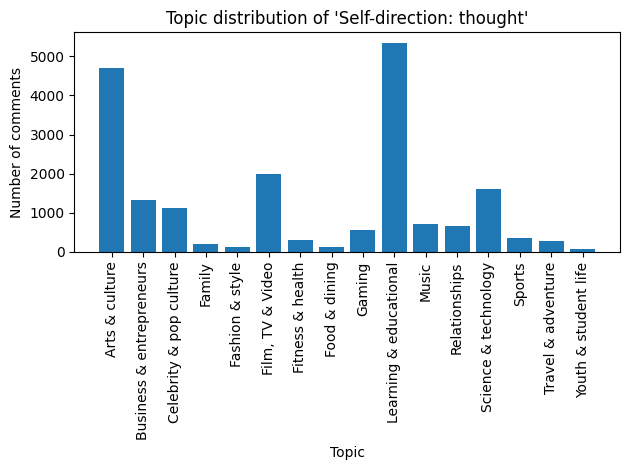

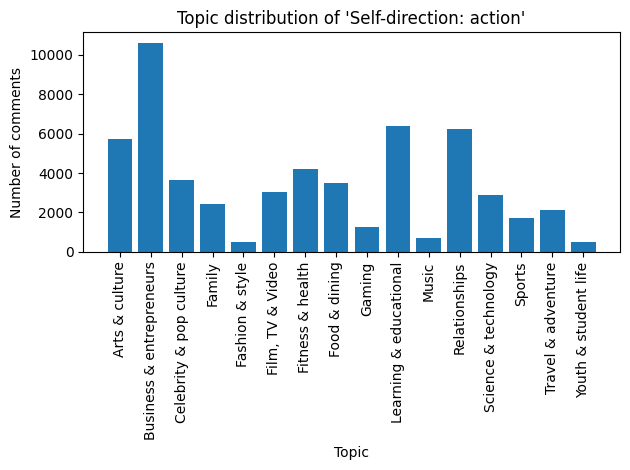

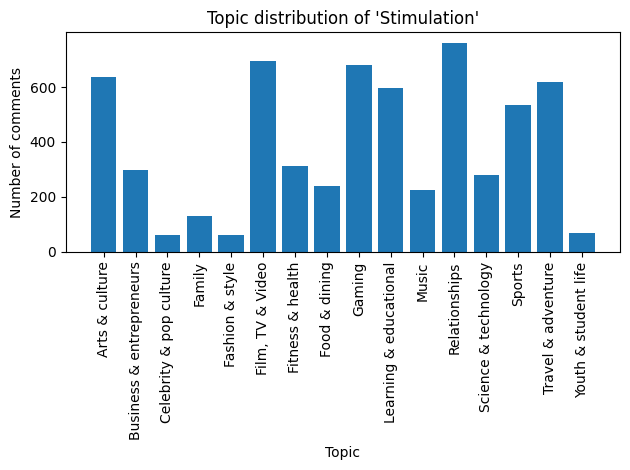

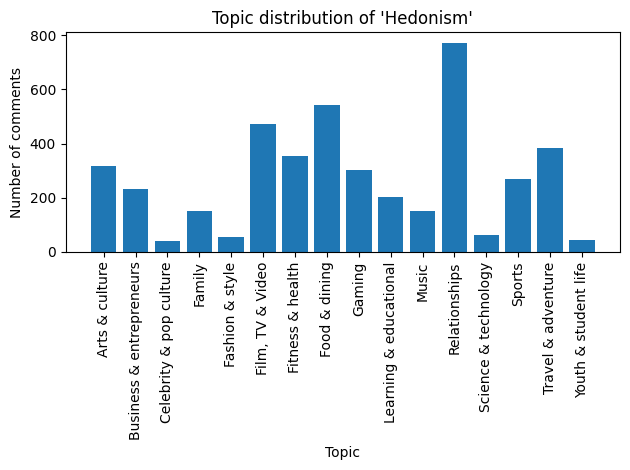

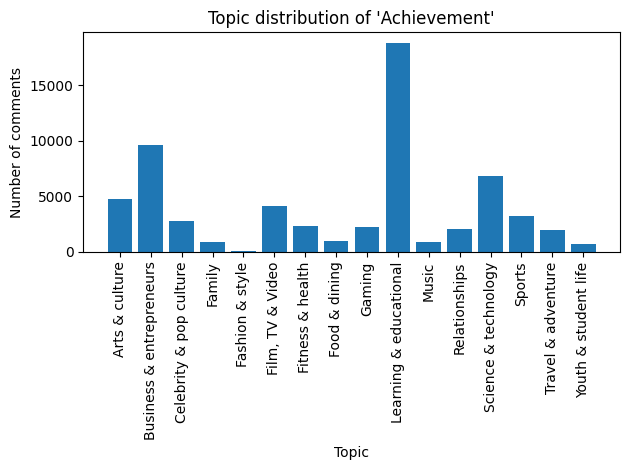

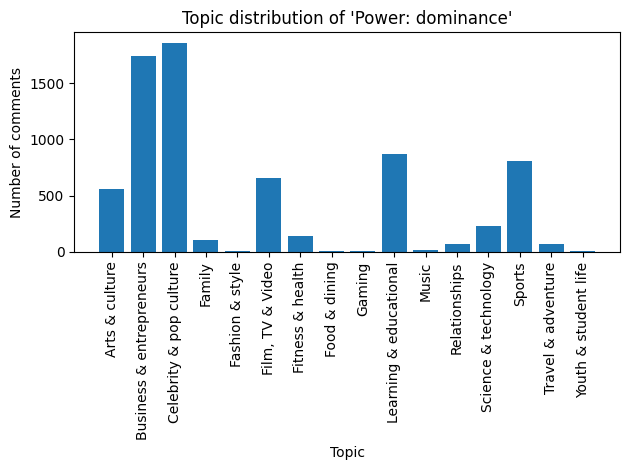

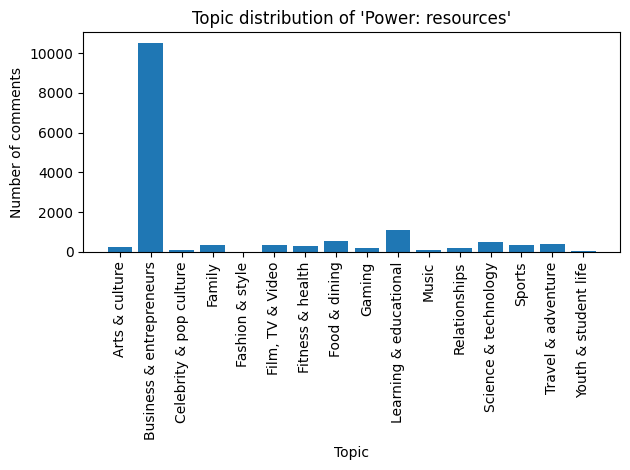

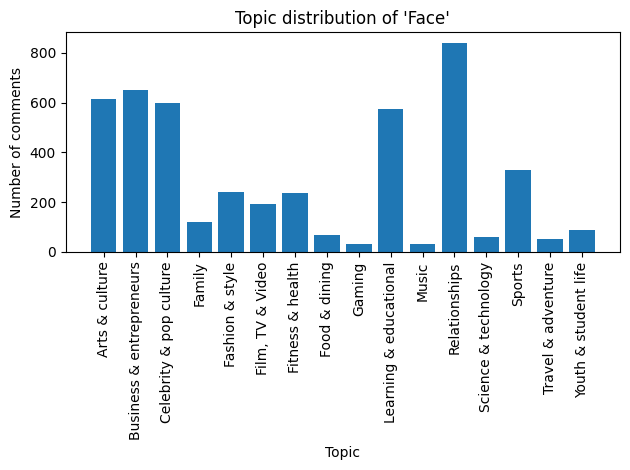

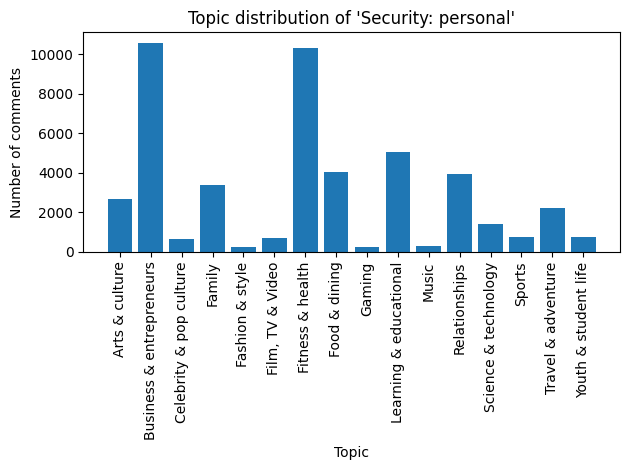

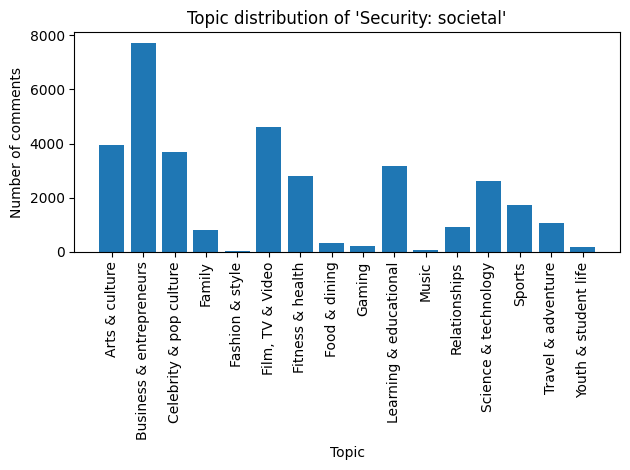

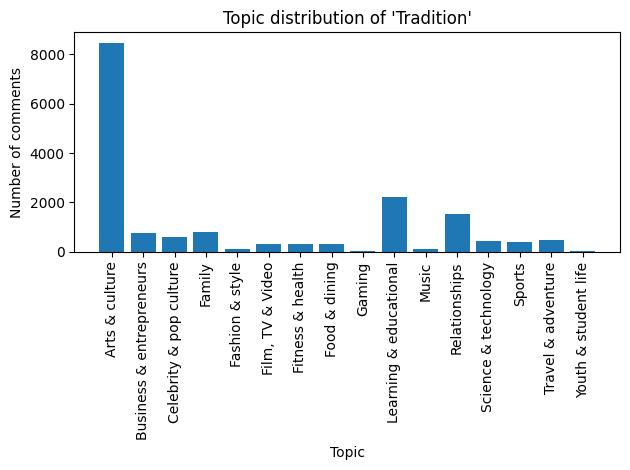

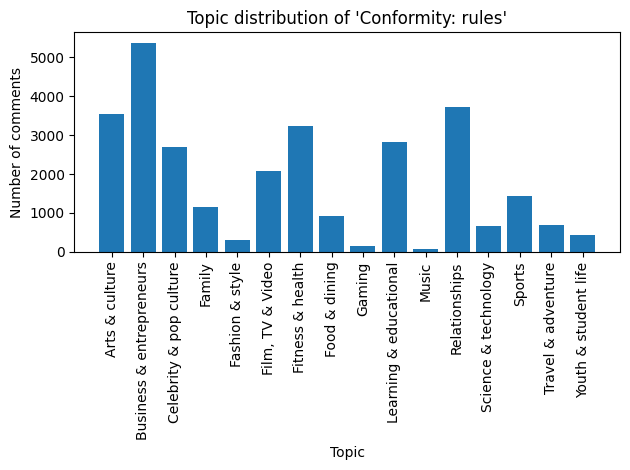

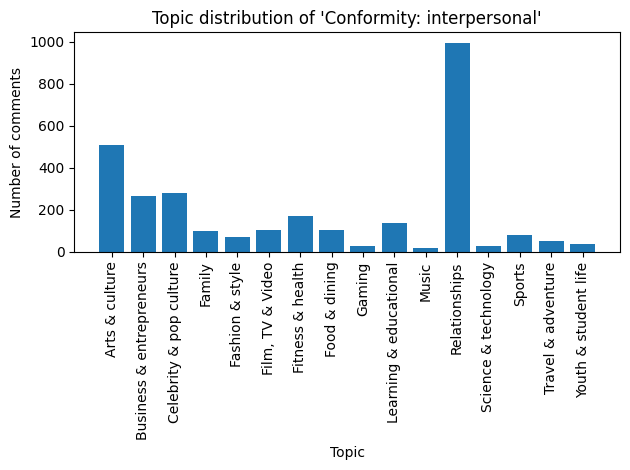

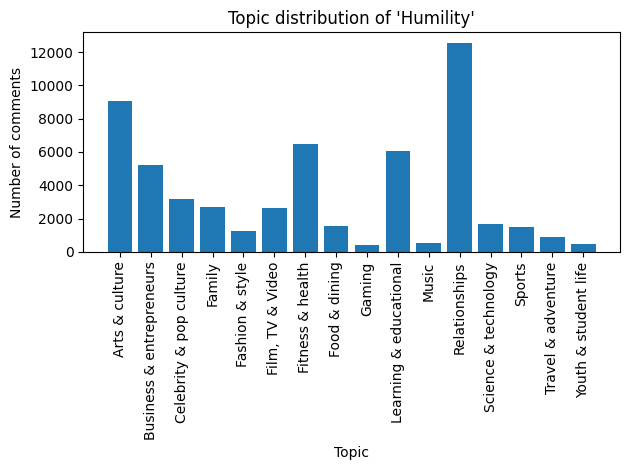

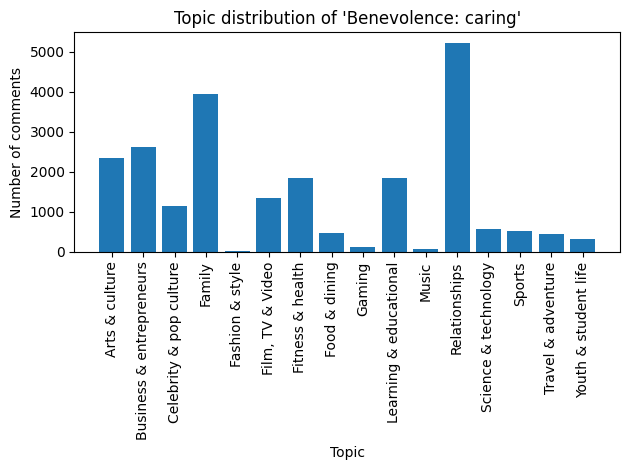

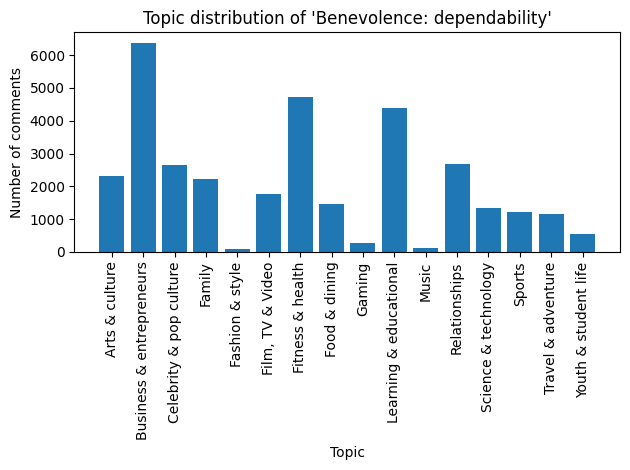

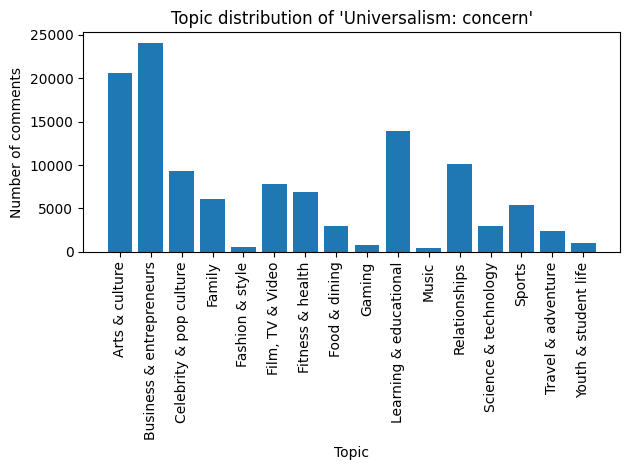

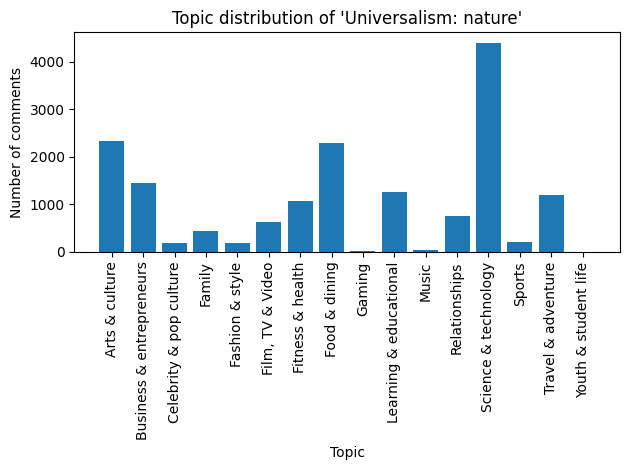

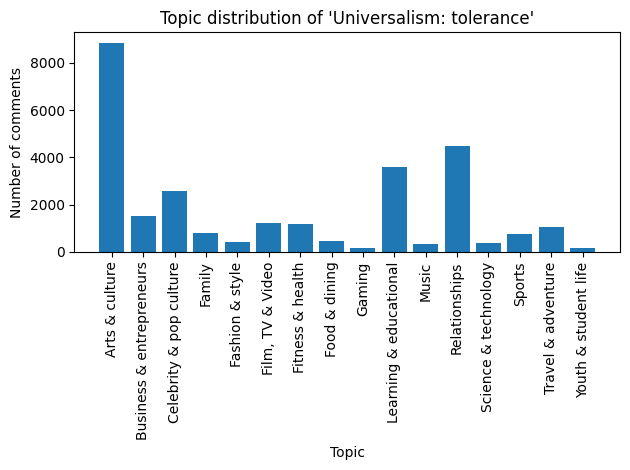

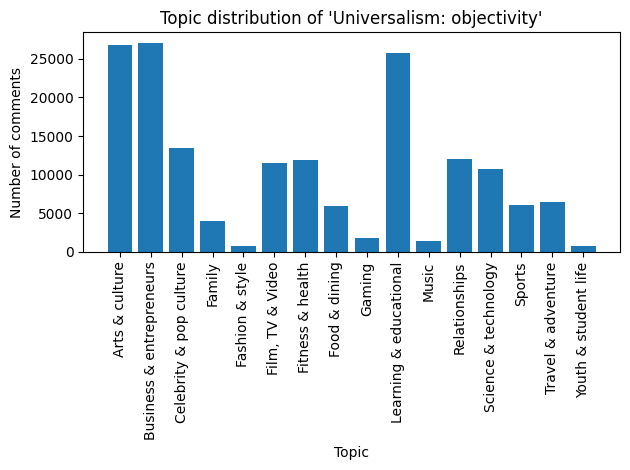

In [7]:
# Plots topic distribution for each human value
for value_idx, value in enumerate(value_labels):
    plt.bar(topic_labels, count_topic_per_value[value_idx])
    plt.xlabel("Topic")
    plt.ylabel("Number of comments")
    plt.title(f"Topic distribution of \'{value}\'")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join("plots", "topic_distrib_" + str(value_idx) + ".pdf"))
    plt.show()